# import, load and filter data

LOADING PPSEQ DATA


      done
back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5
back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5


LOADING BEHAV DATA
      A corresponding time span has been found. Time span set to [5400, 6000]


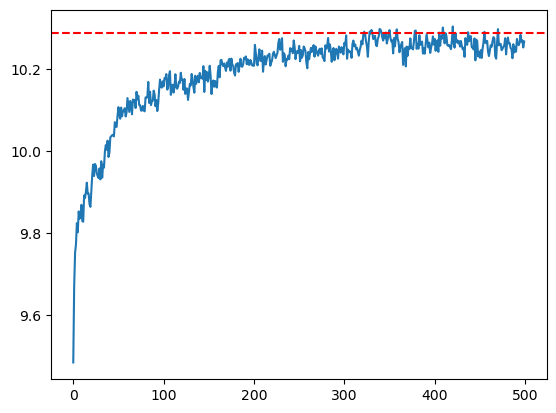

100%|██████████| 159426/159426 [00:34<00:00, 4578.64it/s]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_2156\2292043876.py:132: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  unmasked_spikes_df.sequence_type_adjusted[np.where(unmasked

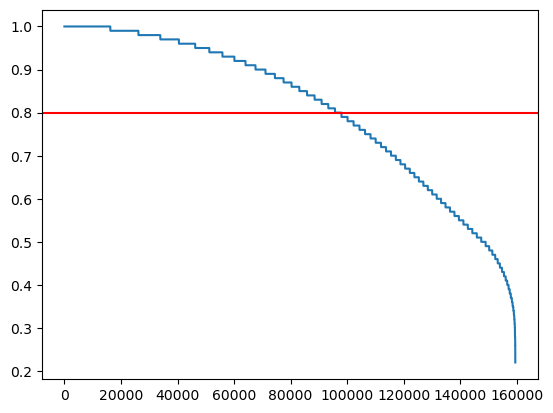

In [2]:
from Utilities.utils import *

current_working_dir = os.path.join(Path(os.getcwd()).parent,'data') 
pp_file = current_working_dir + r'\preproc\Awake\178_1_7_run_2701023_1720'

mouse_session_recording = pp_file.split('\\')[-1].split('_')[0] + '_' + pp_file.split('\\')[-1].split('_')[1] + '_' + pp_file.split('\\')[-1].split('_')[2] 

dat_path = current_working_dir + r'\preproc\Awake\behaviour\\'

tracking_path = current_working_dir + r'\preproc\Awake\tracking\\'

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
## LOAD 
print("LOADING PPSEQ DATA")
print('\n')
#The assignment history frame (assigment_hist_frame.csv): Spikes by iterations, how each spike is assigned to a sequence ID (in latent_event_hist) or to background (-1)
assignment_history_df = pd.read_csv(pp_file + r"\assigment_hist_frame.csv")

# latent_event_hist.csv: history of latent events. All latent events across all iterations have a row
latent_event_history_df = pd.read_csv(pp_file + r"\latent_event_hist.csv")

# seq_type_log_proportions: log p of each type of sequence at each iteration
seq_type_log_proportions_df = pd.read_csv(pp_file + r"\seq_type_log_proportions.csv")

# neuron_responses.csv: iterations x neurons by 3(number of sequences). Each neuron has three parameters per sequence to describe how it is influenced by each sequence type. 
# Each iteration these are resampled, therefore there are number of neurons by iterations by 3 by number of sequences of these numbers.
neuron_response_df = pd.read_csv(pp_file + r"\neuron_response.csv")

log_p_hist_df = pd.read_csv(pp_file + r"\test_log_p_hist.csv")

unmasked_spikes_df = pd.read_csv(pp_file + r"\unmasked_spikes.csv")

bkgd_log_proportions_array = pd.read_csv(pp_file + r"\bkgd_log_proportions_array.csv")


# Opening JSON file
f = open(pp_file + r'\config_file.json')
# returns JSON object as a dictionary
config = eval(json.load(f))
print(f'      done')

back_p1,back_p2,back_p3,back_p4,back_p5 = load_H5_ports(tracking_path,'back')

## LOAD behaviour data
print('\n')
print("LOADING BEHAV DATA")

## load in the timespan used for pppseq:
input_params_path = os.path.join(pp_file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
# Opening JSON file
f = open(input_params_path)
# returns JSON object as 
# a dictionary
input_config = json.load(f)
behav_time_interval_start = input_config['time_span'][0]
print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")
t_difference = np.diff(behav_time_interval_start)[0]

### load in behaviour data:
behav_sync = pd.read_csv(dat_path + '\Behav_Ephys_Camera_Sync.csv')


behav_mask = (behav_sync.PokeIN_EphysTime>behav_time_interval_start[0])*(behav_sync.PokeIN_EphysTime<behav_time_interval_start[1])
poke_in_times = (behav_sync[behav_mask].PokeIN_EphysTime) - behav_time_interval_start[0]
ports = behav_sync[behav_mask].Port


# -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

#find max value

# find 95% of growth value and when it crossed this
max_ = max(log_p_hist_df.x1)
min_ = min(log_p_hist_df.x1)
growth = max_ - min_
_prcntile =  max_ - (0.02 * growth)

## model log likley hood curve
plt.plot(log_p_hist_df.x1)
plt.axhline(y=_prcntile, color='r', linestyle='--')

plt.show()

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

## macth seq id to seq type across itterations

# Initialize an empty df to store the result
seq_types_df = pd.DataFrame()

# Iterate through the range
# for iteration_ in tqdm(range(400, 500)):
for iteration_ in tqdm(range(200, 300)):

    # Extract the relevant column from the assignment history dataframe
    assignment_history_df_split = assignment_history_df[str(list(assignment_history_df)[iteration_])]

    # Get the index of the -1 split markers in the latent event history dataframe
    end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
    # Extract the relevant portion of the latent event history dataframe
    latent_event_history_df_split =  latent_event_history_df[end_markers[iteration_-1]:end_markers[iteration_]]

    # Create a dictionary from the dataframe for faster lookups
    df_dict = latent_event_history_df_split.set_index('assignment_id')['seq_type'].to_dict()

    # Match the sequence ID to the sequence type
    seq_type = find_corresponding(assignment_history_df_split,df_dict)

    # Append the result to the df
    seq_types_df[str(iteration_+1)] = seq_type


proportion = []
seq_type = []
for index in tqdm(range(len(seq_types_df))):
    row = seq_types_df.loc[index]
    seq_type += [statistics.mode(row)] 
    proportion += [np.count_nonzero(row == statistics.mode(row)) / len(row)]

# add seq type to dataframe
unmasked_spikes_df['sequence_type'] = seq_type
# add seq type to dataframe
unmasked_spikes_df['seq_confidence'] = proportion
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

## filter for background confidence :
thresh = max(proportion) *.80
plt.plot(np.sort(proportion)[::-1])
plt.axhline(y = thresh, color = 'r', linestyle = '-')

unmasked_spikes_df['sequence_type_adjusted'] = seq_type
unmasked_spikes_df.sequence_type_adjusted[np.where(unmasked_spikes_df.seq_confidence < thresh)[0]] = -1



# plot ppseq spikes

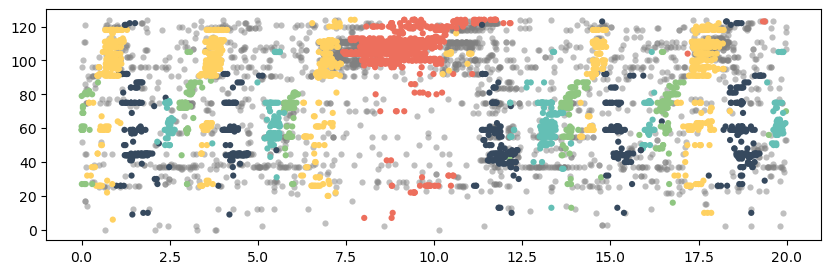

In [3]:
### Plot sequences - basic
timeframe = [0,20]
mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

#define neuron order
neuron_index,ordered_preferred_type = sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=[1,4,3,0,5,2])
# make a list of idndies for each neurons new position
neuron_permute_loc = np.zeros(len(neuron_index))
for i in range(len(neuron_index)):
    neuron_permute_loc[i] = int(list(neuron_index).index(i))
neuron_order = neuron_permute_loc[unmasked_spikes_df.neuron.values.astype(int)-1]

## plotting:
fig, ax = plt.subplots(1, 1,figsize=(10, 3))
# 1. simple raster and tracking alignment plots
dark_blue = '#36495E'
cyan = '#64BFB5'
green = '#8FC681'
yellow = '#FFD161'
orange = '#ED6F5D'
grey = '#ABB9B2'

colors = ['---',green,grey,orange,cyan,dark_blue,yellow,'k']

# plot background in grey 
background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
ax.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'grey' ,alpha=0.5)

# plot spikes without background
background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# ## faster:
ax.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = c_ ,alpha=1)


# individual seq event times

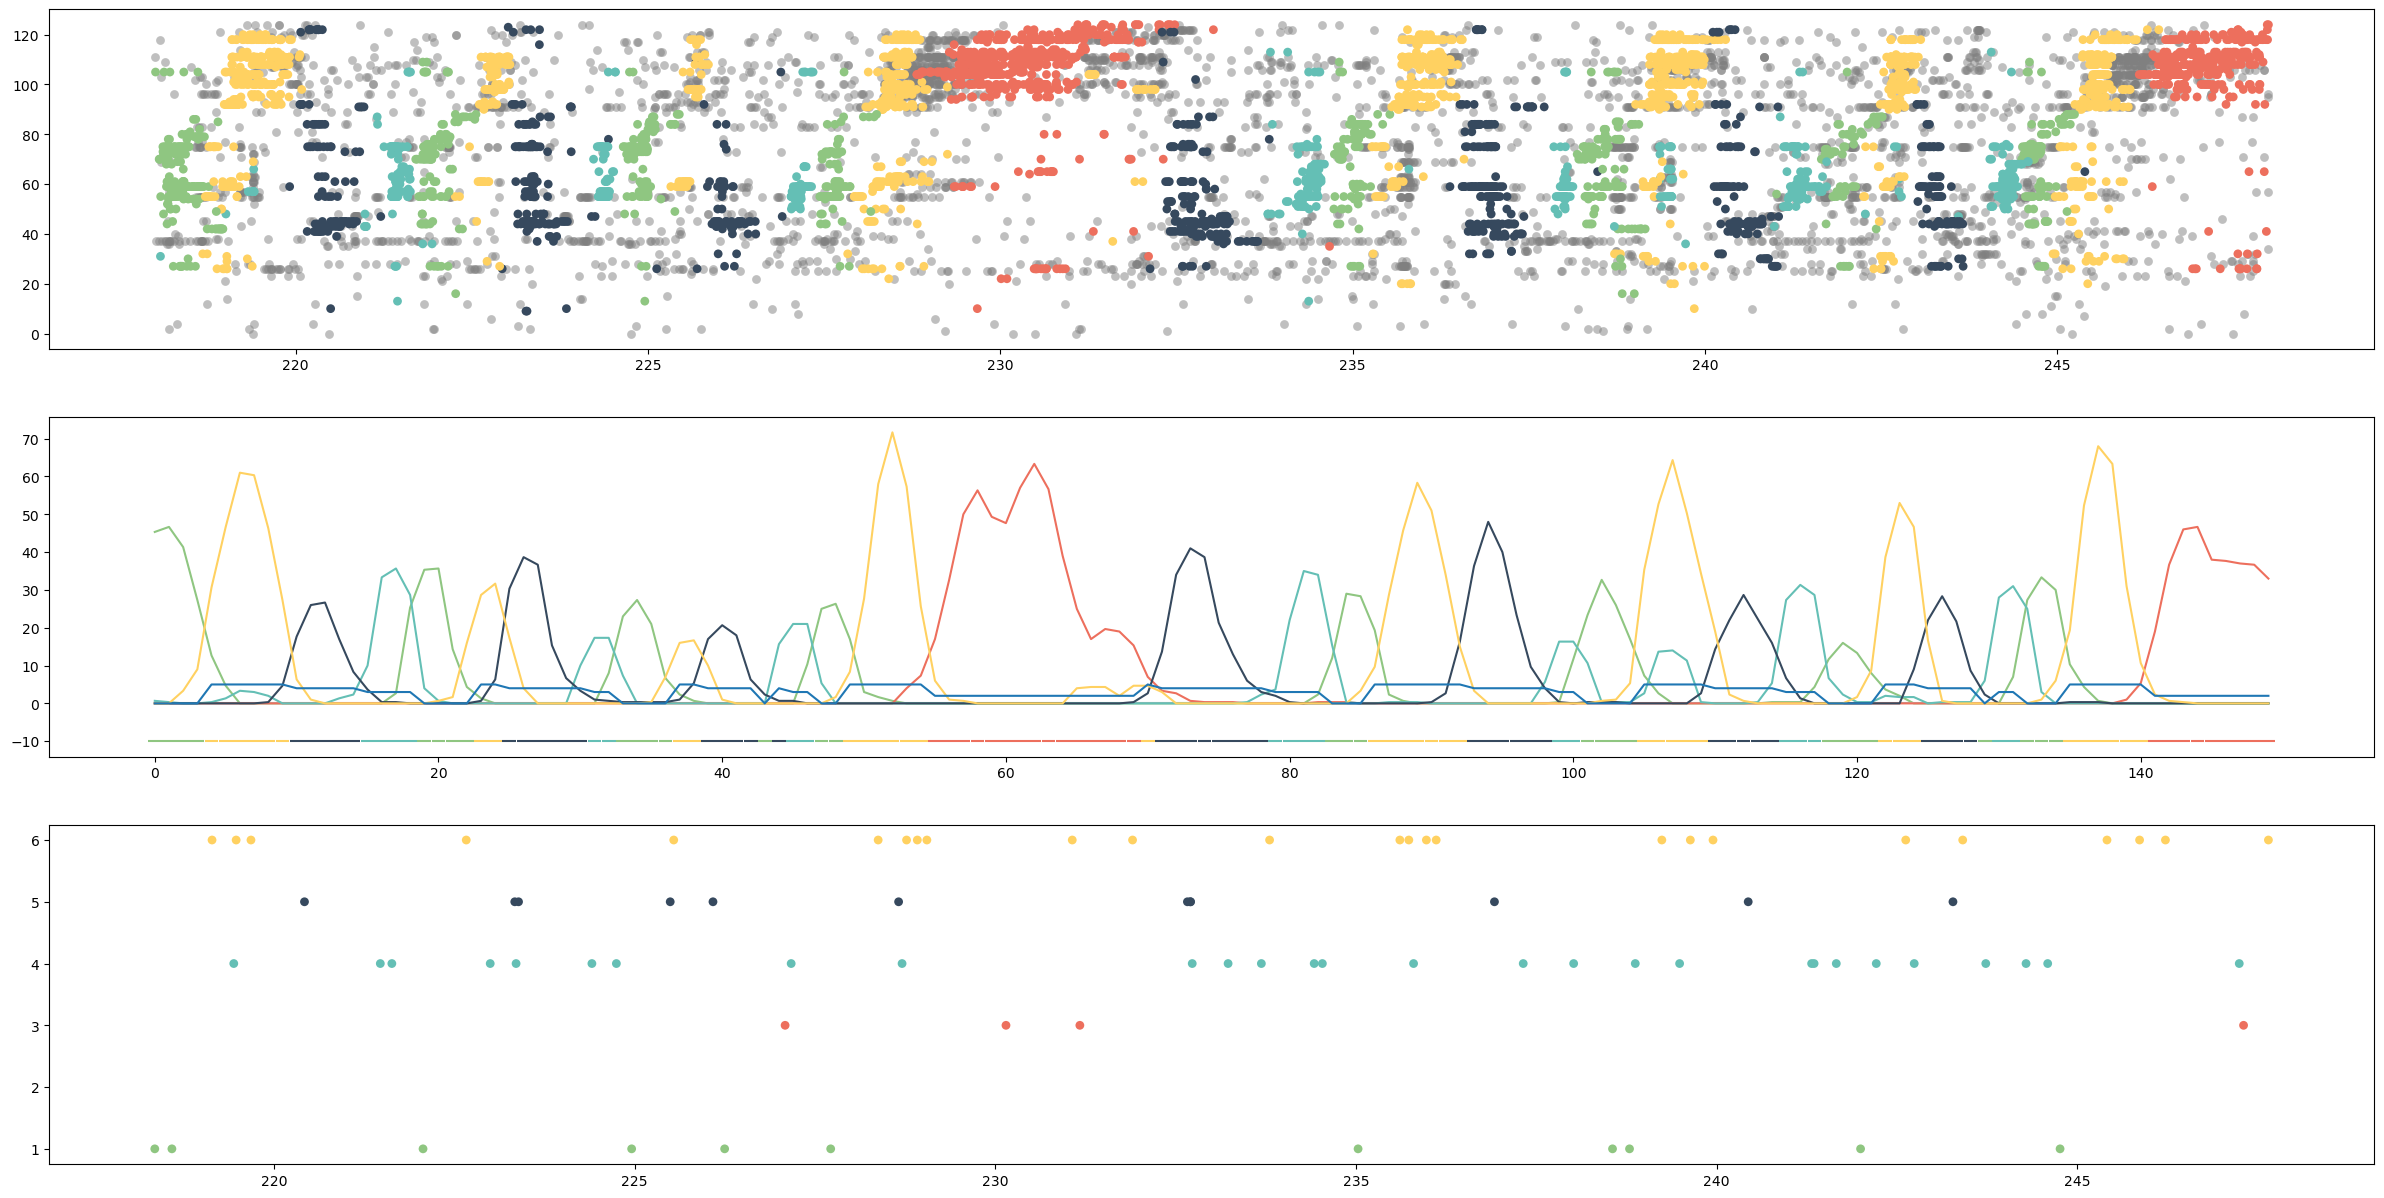

In [4]:
timeframe = [218,248]

#mask
# spikemask
mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(30, 15))

1 ### plot ordered ppseq spikes as above:

# plot background in grey 
background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
ax1.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
# mask to remove background neurons from the color plot
background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


### bin the spiking and plot number of spikes for each seq type
seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
seq_spikes = []
for seq_type_ in seqs:  
    seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

# Define the bin size (in this case, 0.2s)
bin_size = 0.2

seq_spike_occurance = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
    seq_spike_occurance += [list(hist)]
    
strt_ = int(timeframe[0]/bin_size)
end_ = int(timeframe[1]/bin_size)

for i in range (1,len(seq_spike_occurance)):
#     ax2.plot(seq_spike_occurance[i][strt_:end_], c = colors[i])
    ax2.plot(convolve_movmean(seq_spike_occurance[i][strt_:end_],3), c = colors[i])
    

## plot the current seq type (based on binned spiking):
nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
max_index= []
max_index += [np.argmax(sublist) for sublist in nth_vectors] 

ax2.plot(max_index[strt_:end_])

ax2.scatter(np.linspace(0,end_ - strt_-1,end_ - strt_),np.ones(end_ - strt_)*-10, marker = '_',color = np.array(colors)[np.array(max_index)+1][strt_:end_], s = 100)

### plot the ppseq latent:

# mask for the timespan
latent_timespan_mask = (latent_event_history_df_split.timestamp>timeframe[0])*(latent_event_history_df_split.timestamp<timeframe[-1])

# ignore anything that is below threshold * max amplitude
thr_ = 0
thresh_value = max(latent_event_history_df_split.amplitude) * thr_


amplitude_mask = latent_event_history_df_split[latent_timespan_mask].amplitude > thresh_value

c_l = np.array(colors)[latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type.values.astype(int)]
ax3.scatter(latent_event_history_df_split[latent_timespan_mask][amplitude_mask].timestamp,latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type ,marker = 'o', s=40, linewidth=0,color = c_l ,alpha=1)



# tracking and seq events aligned

back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5
back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5
['head_centre' 'implant_centre' 'left_ear' 'right_ear' 'tail_base']


Text(0.5, 1.0, 'timeframe = [218, 248]')

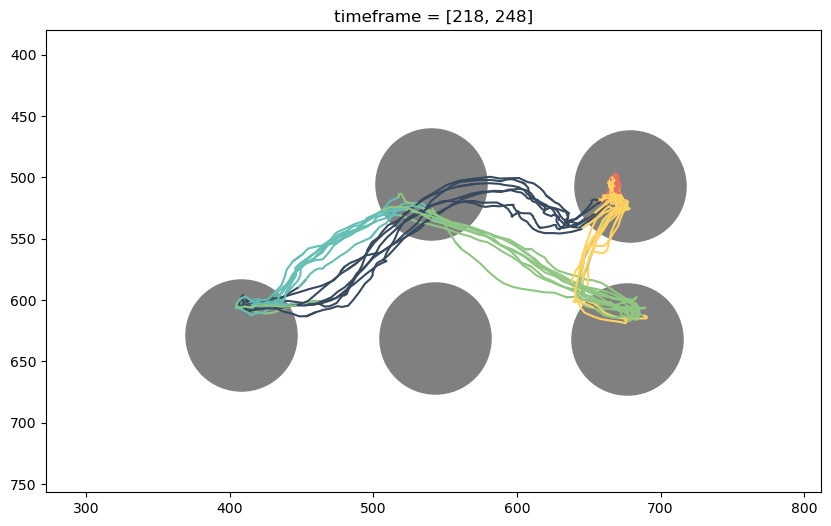

In [5]:
# behav_mask
mask_ = (poke_in_times > timeframe[0]) * (poke_in_times < timeframe[1])
# tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 
# Find the difference between PokeIN_EphysTime and the start of the behavior interval
interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
# Find the offset between the first poke in time and the start of the timeframe
tracking_offset = interval_pokeIn_spike_times[0] - timeframe[0]

# Get the first synced time for the camera in the interval 
interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values[0]
# Align the tracking start with the ephys by subtracting the offset
cam_start_time = interval_cam_times - tracking_offset

# Calculate the number of events based on the timeframe size and bin size
events = np.diff(timeframe)[0] /bin_size 
# Create a list for start times, with the first start time being the camera start time converted to timestamps - 60fps
start_ts = [cam_start_time * 60 ]
# Convert the bin size to timestamps - 60fps
bin_ts = bin_size * 60

# Create an empty list for end times
end_ts = []
# Loop through the number of events
for i in range(int(events)):
    # If it is not the first event, set the start time as the end time of the previous event
    if i > 0:
        start_ts += [end_ts[i-1]]
    # Add the current start time plus the bin size to the list of end times
    end_ts += [start_ts[i] + bin_ts] 

    
back_head_centre = load_H5_bodypart(tracking_path,'back','head_centre')

nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(10, 6))

for ind, ax in enumerate(fig.axes):
    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 80)
    for i in range(int(events)):
        ax.plot(back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1],back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color = np.array(colors)[np.array(max_index)+1][strt_:end_][i], alpha = 1)

        
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)

    ax.invert_yaxis()
    
ax.set_title('timeframe = ' + str(timeframe))
    


#  Average task space - tracking

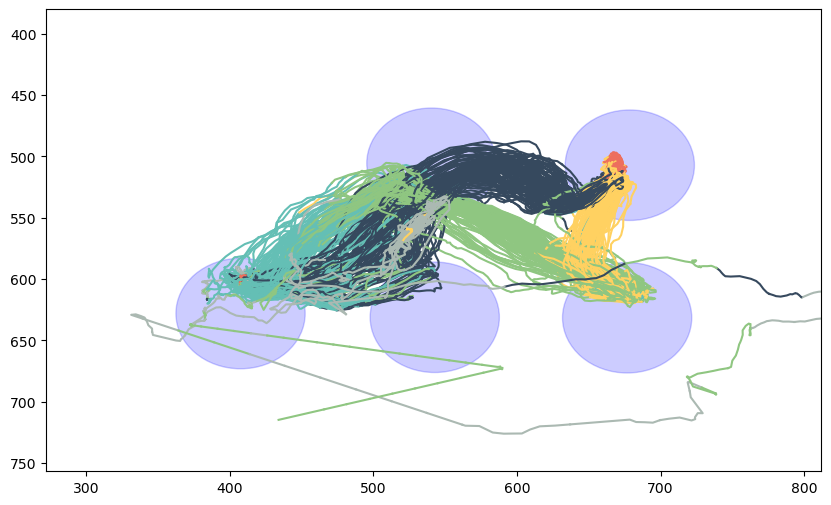

In [6]:
# behav_mask for the whole analysed time:
mask_ = (poke_in_times > 0) * (poke_in_times < np.diff(behav_time_interval_start)[0])
# tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

# Find the difference between PokeIN_EphysTime and the start of the behavior interval
interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
# Find the offset between the first poke in time and the start of the timeframe
tracking_offset = interval_pokeIn_spike_times[0]

# Get the first synced time for the camera in the interval 
interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values
# Align the tracking start with the ephys by subtracting the offset
cam_start_time = interval_cam_times[0] - tracking_offset
cam_end_time = cam_start_time + np.diff(behav_time_interval_start)[0]

cam_start_ts = cam_start_time * 60
cam_end_ts = cam_end_time * 60

## work out colors:

full_timeframe = [0,np.diff(behav_time_interval_start)[0]]
# Calculate the number of events based on the timeframe size and bin size
events = np.diff(full_timeframe)[0] /bin_size 
# Convert the bin size to timestamps - 60fps
bin_ts = bin_size * 60


### bin the spiking and plot number of spikes for each seq type
seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
seq_spikes = []
for seq_type_ in seqs:  
    seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]
    
seq_spike_occurance = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
    seq_spike_occurance += [list(hist)]



## plot the current seq type (based on binned spiking):
nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
max_index= []
max_index += [np.argmax(sublist) for sublist in nth_vectors] 

frame_colors= []
bin_colors = np.array(colors)[np.array(max_index)+1]
for bin_color in bin_colors:
    frame_colors += [bin_color] * int(bin_ts)
    
    
# Loop through the number of events to split this up for plotting:
seg_start_ts = [cam_start_ts] 
seg_end_ts= []
for i in range(len(bin_colors)):
    # If it is not the first event, set the start time as the end time of the previous event
    if i > 0:
        seg_start_ts += [seg_end_ts[i-1]]
    # Add the current start time plus the bin size to the list of end times
    if i == len(bin_colors)-1:
        seg_end_ts += [cam_end_ts] 
    else:
        seg_end_ts += [seg_start_ts[i] + bin_ts] 
        

nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(10, 6))

for ind, ax in enumerate(fig.axes):
    port_centroids = []
    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ## define rings around important ports: port 5, port2, port 3, port4
        port_centroid = np.median(item['interped_x'].values),np.median(item['interped_y'].values)
        radius = 45
        circle1 = plt.Circle(port_centroid, radius, color='blue', alpha = 0.2)
        ax.add_patch(circle1)
        port_centroids += [port_centroid]


    ## plot binned segments individually
    for i in range(len(bin_colors)):
        x = back_head_centre['interped_x'].values[int(seg_start_ts[i])-1:int(seg_end_ts[i])]
        y = back_head_centre['interped_y'].values[int(seg_start_ts[i])-1:int(seg_end_ts[i])]
        ax.plot(x,y,'-',color = bin_colors[i], alpha = 1)



    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)

    ax.invert_yaxis()

    #save out this data for later plotting and alanylis 
    # trim it down - it doesnt match because we add extra an extra time bin onto the end so that we know what the final left over frames should be coloree
    total_frames = len(back_head_centre['interped_x'].values[int(cam_start_ts)-1:int(cam_end_ts)])
    
    all_frame_colors = frame_colors[0:total_frames]
    all_x_position = back_head_centre['interped_x'].values[int(cam_start_ts)-1:int(cam_end_ts)]
    all_y_position = back_head_centre['interped_y'].values[int(cam_start_ts)-1:int(cam_end_ts)]
    
        
        

filter for reasonably clean seq attempts

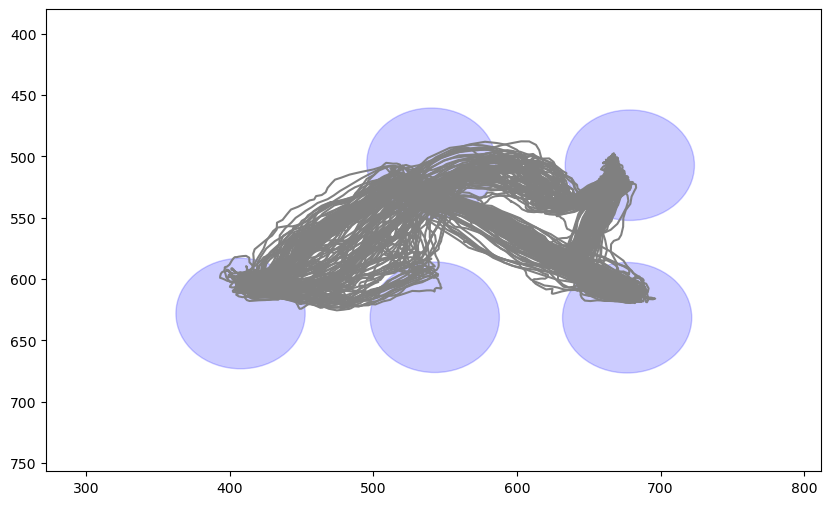

In [7]:
## find times it comes within ble circles (distance is less than radius)
## find times it does so in the order 5,2,3,4,5 with less than 2s between 
coords = []
for ind_,item in enumerate(all_x_position):
    coords += [[item,all_y_position[ind_]]]
    
threshold_breaks = np.zeros(len(coords))
# for each port we care about find where the mouse breaks the distcance threshold
for ind_ in range(1,len(port_centroids)):
    threshold = radius
    target = port_centroids[ind_]
    closest,indicies = closest_points(target, coords, threshold)
    threshold_breaks[indicies] = ind_ + 1

## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
time_filter = 3 #in s
frame_filter = int(time_filter / (1/60))


start_ind, end_ind = find_p5_segments(threshold_breaks, frame_filter, find_next_val)

filtered_split_trajectories_x_positions = []
filtered_split_trajectories_y_positions = []
filtered_split_trajectories_frame_colors = []

# plot these filtered trajectories:

nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(10, 6))

for ind, ax in enumerate(fig.axes):
    
    for port_centroid in port_centroids:
        ## define rings around important ports: port 5, port2, port 3, port4
        radius = 45
        circle1 = plt.Circle(port_centroid, radius, color='blue', alpha = 0.2)
        ax.add_patch(circle1)
    
for i in range(len(start_ind)):

    
    ax.plot(all_x_position[start_ind[i]:end_ind[i]],all_y_position[start_ind[i]:end_ind[i]],'-', color = 'grey', alpha = 1)

    filtered_split_trajectories_x_positions += [all_x_position[start_ind[i]:end_ind[i]]]
    filtered_split_trajectories_y_positions += [all_y_position[start_ind[i]:end_ind[i]]]
    filtered_split_trajectories_frame_colors += [all_frame_colors[start_ind[i]:end_ind[i]]]
    
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)

    
    ax.invert_yaxis()

find port crossing points

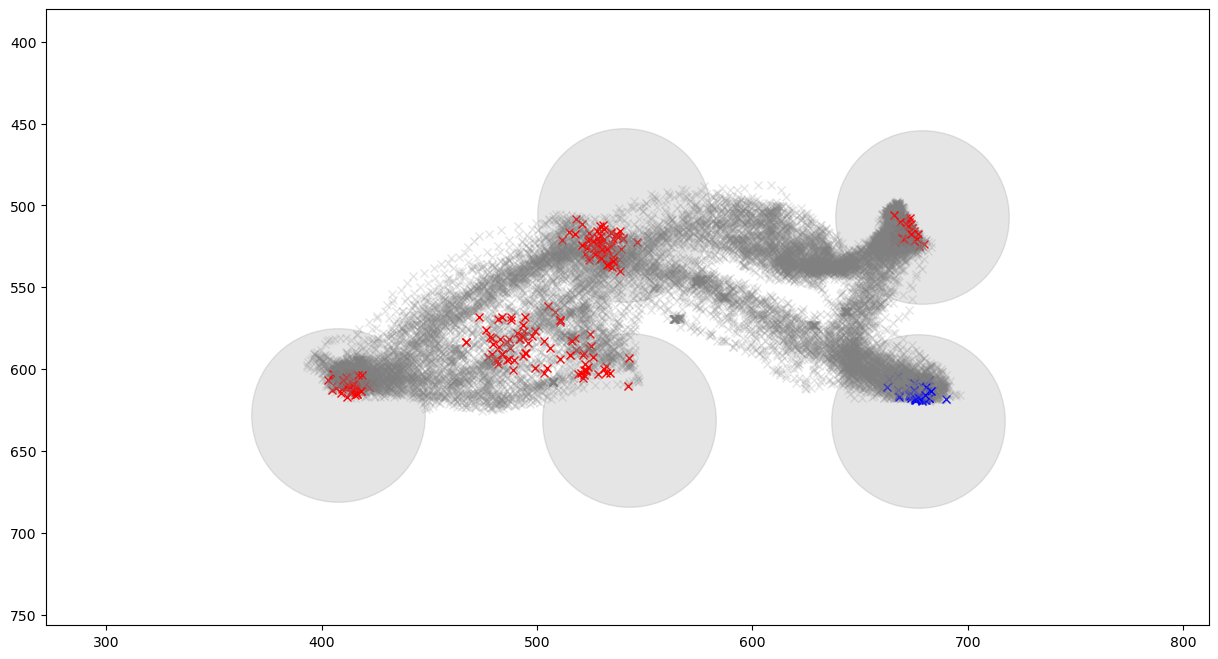

In [8]:
############################################## find points in each trajectory that are closest to the end port 

split_trajects_port_points = []
split_trajects_port_indicies = []
combined_xy_trajectories = []

for i in range(len(filtered_split_trajectories_x_positions)):
    traject_coords = []
    for ind_,item in enumerate(filtered_split_trajectories_x_positions[i]):
        traject_coords += [[item,filtered_split_trajectories_y_positions[i][ind_]]]

    split_trajects_port_points_,split_trajects_port_indicies_ = find_closest_points(traject_coords,port_centroids)
    
    split_trajects_port_points += split_trajects_port_points_
    split_trajects_port_indicies += split_trajects_port_indicies_
    combined_xy_trajectories += [traject_coords]

nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):

    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)
    ax.invert_yaxis()
    
    for i_ in range(len(filtered_split_trajectories_x_positions)):
        for i in range(len(filtered_split_trajectories_x_positions[i_])):
            if i in split_trajects_port_indicies[i_]:
                _colors_ = 'red'
                alpha_ = 1
                if i == split_trajects_port_indicies[i_][-2]:
                    _colors_ = 'blue'
            else:
                _colors_ = 'grey'
                alpha_ = 0.2
            ax.plot(filtered_split_trajectories_x_positions[i_][i],filtered_split_trajectories_y_positions[i_][i],'x', color = _colors_, alpha = alpha_ )
            


split trajectories into sectional segments

In [9]:
segments_1 = []
segments_2 = []
segments_3 = []
segments_4 = []
segments_5 = []
for ind,traject_ in enumerate(combined_xy_trajectories):
    segments_1 += [traject_[0:split_trajects_port_indicies[ind][0]]]
    segments_2 += [traject_[split_trajects_port_indicies[ind][0]:split_trajects_port_indicies[ind][1]]]
    segments_3 += [traject_[split_trajects_port_indicies[ind][1]:split_trajects_port_indicies[ind][2]]]
    segments_4 += [traject_[split_trajects_port_indicies[ind][2]:split_trajects_port_indicies[ind][3]]]
    segments_5 += [traject_[split_trajects_port_indicies[ind][3]:split_trajects_port_indicies[ind][4]]]

segments = [segments_1] + [segments_2] + [segments_3] + [segments_4] + [segments_5]

curves=segments[-1]
# Find the length of the longest curve
max_length = max([len(curve) for curve in curves])

# Interpolate each curve to the length of the longest curve
interpolated_curves = []
for curve in curves:
    if len(curve) > 0:
        x = [point[0] for point in curve]
        y = [point[1] for point in curve]

        # find lots of points on the piecewise linear curve defined by x and y
        M = max_length
        t = np.linspace(0, len(x), M)
        x_interp = np.interp(t, np.arange(len(x)), x)
        y_interp = np.interp(t, np.arange(len(y)), y)

        interpolated_curves.append([[x, y] for x, y in zip(x_interp, y_interp)])

# # Average the x and y coordinates of all the interpolated curves
average_curve = []
for i in range(max_length):
    x_sum = 0
    y_sum = 0
    for curve in interpolated_curves:
        x_sum += curve[i][0]
        y_sum += curve[i][1]
    average_curve.append([x_sum / len(curves), y_sum / len(curves)])


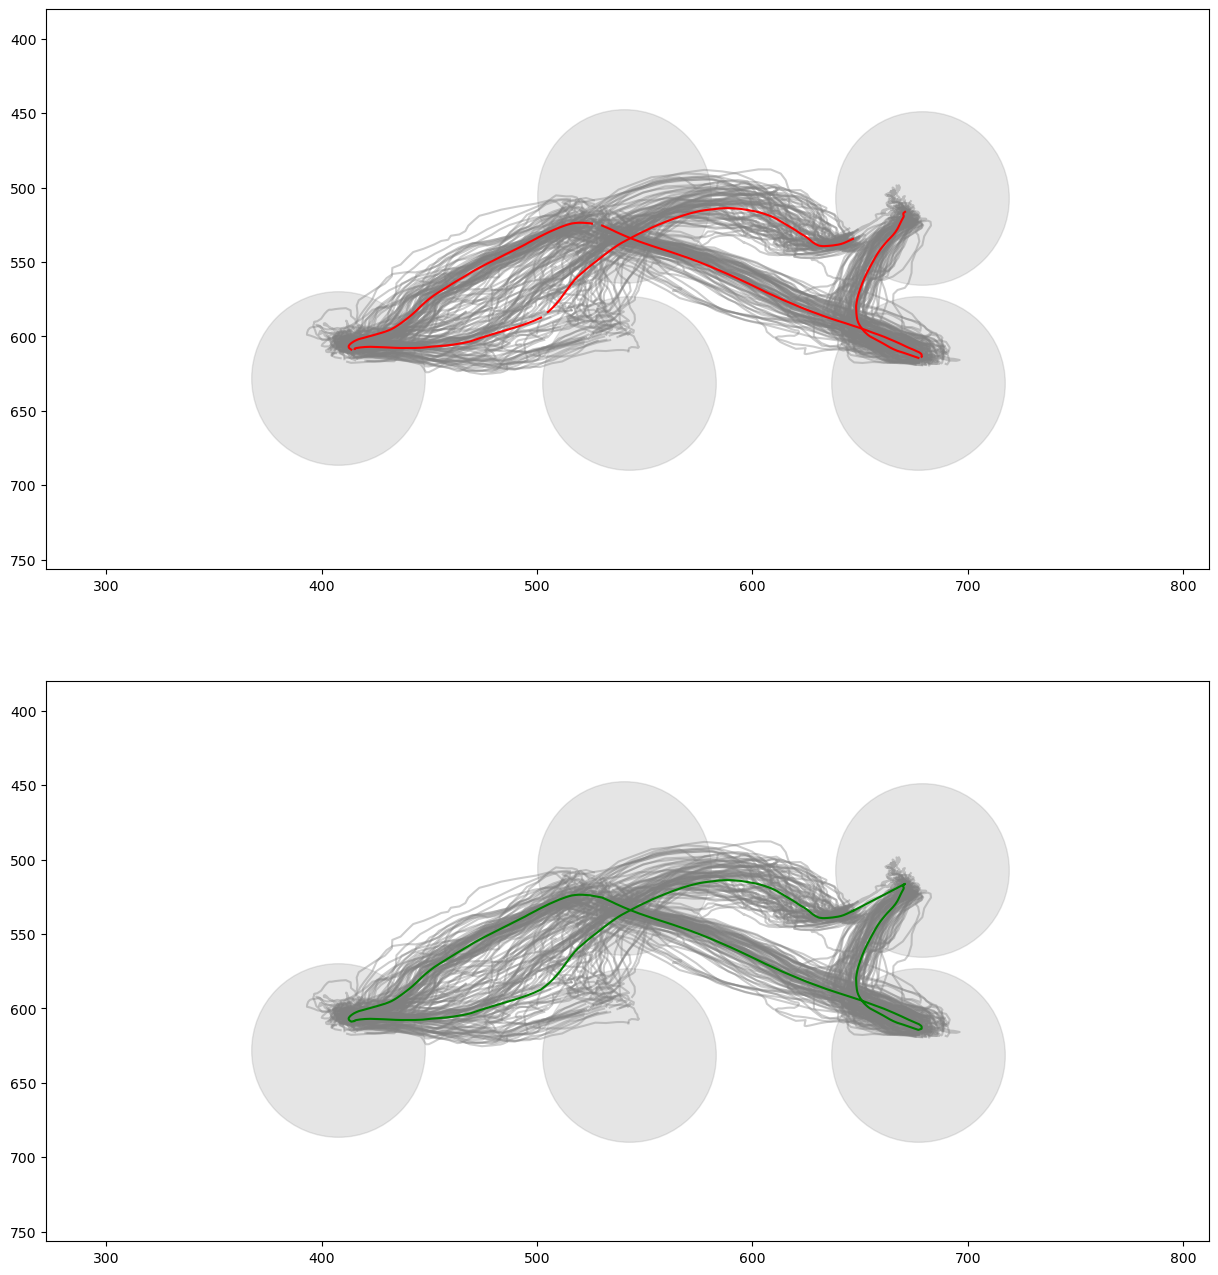

In [10]:

a_curves= []
for segment in segments:
    a_curves += [interpolate_to_longest_and_find_average_curve(segment)]


# Plot the resulting average curve
nrow = 2 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 16))

for ind, ax in enumerate(fig.axes):

    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)
    ax.invert_yaxis()

    for segment in segments:
        for seg_traject in segment:
            x = [point[0] for point in seg_traject]
            y = [point[1] for point in seg_traject]
            ax.plot(x, y, '-', color ='grey',alpha = 0.4)
            
    if ind == 0:
        for a_curve in a_curves:
            x = [point[0] for point in a_curve]
            y = [point[1] for point in a_curve]
            ax.plot(x, y, color = 'red')
    else:
        a_curve_ = []
        for a_curve in a_curves:
            a_curve_ += a_curve
        # add the start back onto the end so that it is a complete loop
        a_curve_ += [a_curve_[0]]

        x = [point[0] for point in a_curve_]
        y = [point[1] for point in a_curve_]
        ax.plot(x, y, '-',color = 'green')




recombine and interpolate to get average curve 

100%|██████████| 662/662 [00:00<00:00, 42592.87it/s]


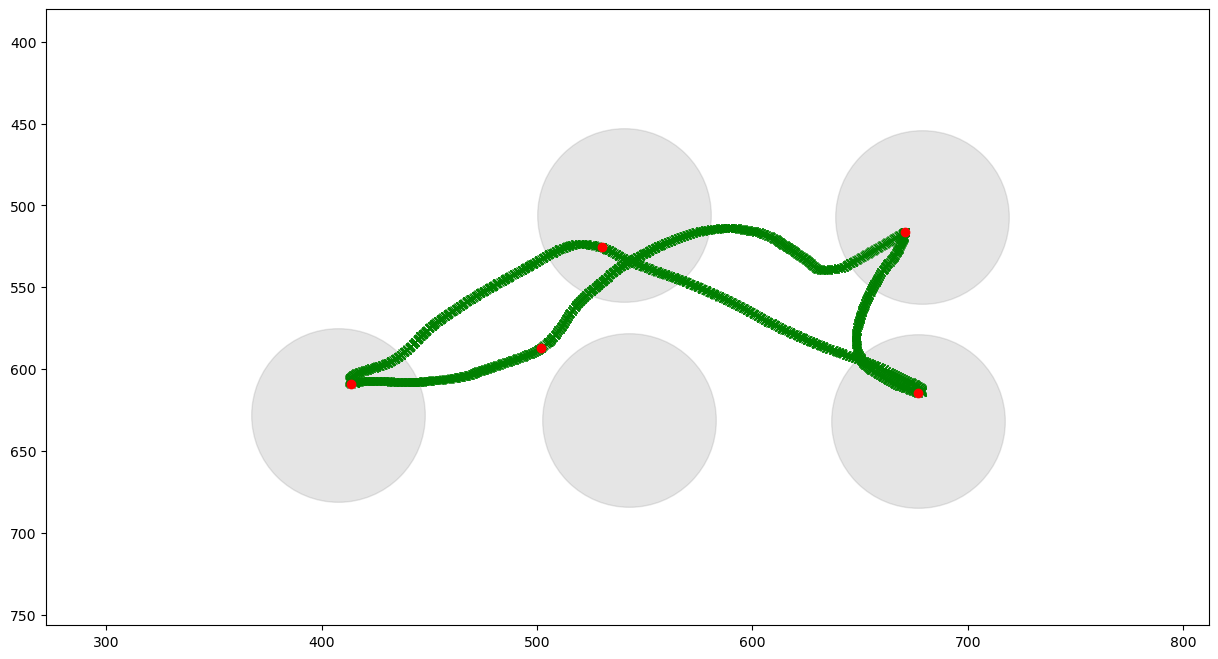

In [11]:

total_length = total_length_of_curve(a_curve_)
# chose number of points you want to construct the curve out of - this will only be roughly fitted as the code does a lot of rounding. This cant be smaller than the current length - ifyou do this is will just keep the curve the same (it can only add points)
num_points = 2000
# number to multiply the segment length to get the rough breakdown so that we get around 1000 in total 
segment_warp_factor = num_points/int(total_length) 


interpolated_av_curve = []
for i in tqdm(range(len(a_curve_))):
    if i>0:
        st_ = a_curve_[i]
        ed_ = a_curve_[i-1]
        seg_distance = math.dist(st_,ed_)
        num_points_to_add = np.round(seg_distance * segment_warp_factor)
        if num_points_to_add >1:
            
            seg = [st_] + [ed_]
            x = [point[0] for point in seg]
            y = [point[1] for point in seg]
            
            M = int(num_points_to_add)
            t = np.linspace(0, len(x), M)
            x_interp = np.interp(t, np.arange(len(x)), x)
            y_interp = np.interp(t, np.arange(len(y)), y)
            
            interpolated_av_curve += ([[x, y] for x, y in zip(x_interp, y_interp)])

            
        else:
            interpolated_av_curve += [a_curve_[i]]
            
            
# find points that are closest to eahc port:
av_curve_closestport_points,av_curve_closestport_indicies = find_closest_points(interpolated_av_curve,port_centroids)
            
nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):
    
    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)
    ax.invert_yaxis()

    x = [point[0] for point in interpolated_av_curve]
    y = [point[1] for point in interpolated_av_curve]
    ax.plot(x, y, 'x',color = 'green')
    
    for index in av_curve_closestport_indicies[0]:
        ax.plot(interpolated_av_curve[index][0],interpolated_av_curve[index][1],'o', color = 'red', alpha = 1 )

        
        

find where seq events land on standard average curve

In [12]:

# work out rolling closest point to av line
closest_indicies = []

# extra piece is added onto the end to try and stop the end bin getting lumped with all of the leftover data  
extra_piece =50

for i in range(len(combined_xy_trajectories)):
    
    # crappy filter added in here to get around weird bug that sometimes occurs
    if split_trajects_port_indicies[i][-1] == split_trajects_port_indicies[i][-2]:
        print('bug')
        split_trajects_port_indicies[i][-2] = split_trajects_port_indicies[i][-1] - 2
    
    #find closest point from start to port to port 2
    traject = combined_xy_trajectories[i][0:split_trajects_port_indicies[i][1]]
    end_segment = av_curve_closestport_indicies[0][1]
    index, dist = closest_point(traject, interpolated_av_curve[0:end_segment+extra_piece])
    closest_inds = list(index)

    #find closest point from port 2 to port 4
    traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][1]:split_trajects_port_indicies[i][3]]
    start_segment = av_curve_closestport_indicies[0][1]
    end_segment = av_curve_closestport_indicies[0][3]
    index, dist = closest_point(traject, interpolated_av_curve[start_segment-extra_piece:end_segment])
    #indicies are calcuated reltive to segment so add on previous segment inds
    closest_inds += list(index+av_curve_closestport_indicies[0][1])
    
    #find closest point from port 4 to port 5
    traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][3]:split_trajects_port_indicies[i][4]]
    start_segment = av_curve_closestport_indicies[0][3]
    end_segment = av_curve_closestport_indicies[0][4]
    index, dist = closest_point(traject, interpolated_av_curve[start_segment-10:end_segment+extra_piece])
    closest_inds += list(index+av_curve_closestport_indicies[0][3])

    #find closest point from port 5 to the rest
    traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][4]::]
    start_segment = av_curve_closestport_indicies[0][4]
    index, dist = closest_point(traject, interpolated_av_curve[start_segment-extra_piece::])
    closest_inds += list(index+av_curve_closestport_indicies[0][4])


    closest_indicies += [closest_inds]


# covert colors back into numbers :
seq_types = []
for i in range(len(filtered_split_trajectories_frame_colors)):
    seq_type = []
    for string in filtered_split_trajectories_frame_colors[i]:
        index = colors.index(string)
        seq_type.append(index)
    seq_types += [seq_type]

# work out number of bins:
max_value = float('-inf')
for array in closest_indicies:
    for value in array:
        if value > max_value:
            max_value = value

# work out how often each type occurs at each point
standardized_seq_occurrences = [[] for i in range(max_value+1)]

for i_ in range(len(closest_indicies)):
    for i in range(len(closest_indicies[i_])):
        index = closest_indicies[i_][i]
        if not np.isnan(index):
            seq_type = seq_types[i_][i]
            standardized_seq_occurrences[index].append(seq_type)

# count each event for each bin:
seq_IDs = np.unique(unmasked_spikes_df.sequence_type_adjusted)[1::].astype(int)

count1 = []
count2 = []
count3 = []
count4 = []
count5 = []
count6 = []
       
for bin_ in standardized_seq_occurrences:
    count1 += [bin_.count(1)]
    count2 += [bin_.count(2)]
    count3 += [bin_.count(3)]
    count4 += [bin_.count(4)]
    count5 += [bin_.count(5)]
    count6 += [bin_.count(6)]
    
counts = [count1] + [count2] + [count3] + [count4] + [count5] + [count6]



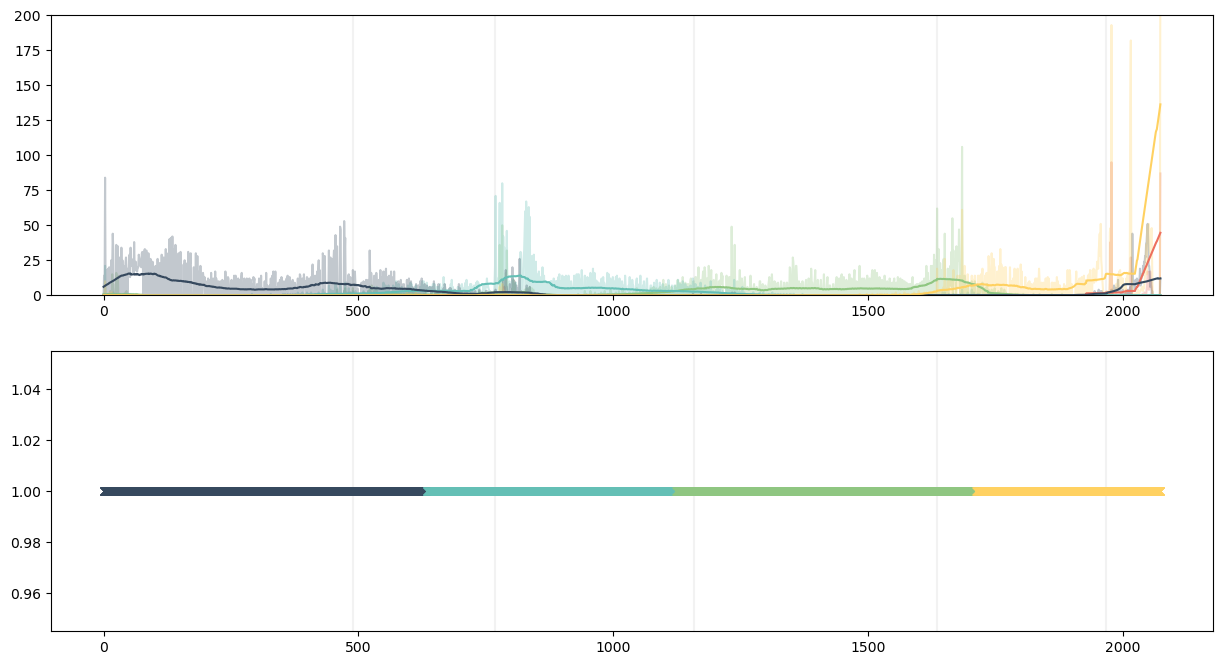

In [13]:

nrow = 2 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):

    for item in av_curve_closestport_indicies[0]:
        ax.axvline(item,color = 'grey', alpha = 0.1)
    
    if ind == 0:

        ax.plot(count1,color = colors[1],alpha = 0.3)
        ax.plot(count2,color = colors[2],alpha = 0.3)
        ax.plot(count3,color = colors[3],alpha = 0.3)
        ax.plot(count4,color = colors[4],alpha = 0.3)
        ax.plot(count5,color = colors[5],alpha = 0.3)
        ax.plot(count6,color = colors[6],alpha = 0.3)



        smoothed_counts = []
        for i,count in enumerate(counts):
            ax.plot(convolve_movmean(count,100), color = colors[i+1] )
            smoothed_counts += [convolve_movmean(count,100)]
        ax.set_ylim(0,200)
        
    else:

        dominant = []
        for item in conactinate_nth_items(smoothed_counts[:]):
            dominant += [np.argmax(item)+1]

        for i in range(len(dominant)):
            plt.plot(np.linspace(0,len(dominant)-1,len(dominant))[i],1,'x', color = (np.array(colors)[dominant])[i])
        
        for i in range(len(dominant)):
            ax.plot(np.linspace(0,len(dominant)-1,len(dominant))[i],1,'x', color = (np.array(colors)[dominant])[i])
        


warp to comparable standard space

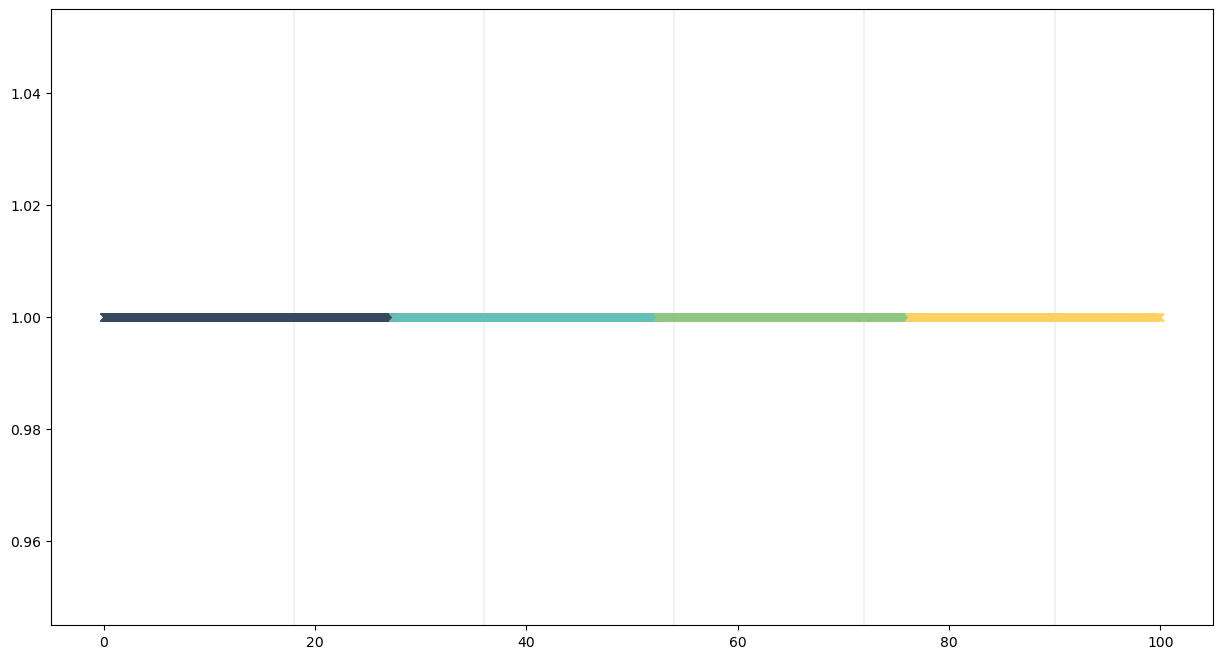

In [14]:
# warp this to standard space:

def map_y_to_x(y, indices, x_positions):
    x = np.zeros_like(y)
    for i, idx in enumerate(indices):
        x[idx] = x_positions[i]
    x = np.interp(np.arange(len(y)), indices, x_positions)
    x = np.interp(x, (x.min(), x.max()), (0, 100))
    return x

# Example y data and indices to map to x positions
warp_points = [0] + av_curve_closestport_indicies[0] + [len(dominant)-1]
x_positions = [0,18, 36, 54, 72, 90,100]
x_values = np.linspace(0,len(dominant)-1,len(dominant))
warped_x = map_y_to_x(x_values, warp_points, x_positions)

nrow = 1
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):

    for item in x_positions[1:-1]:
        ax.axvline(item,color = 'grey', alpha = 0.1)
    
    for i in range(len(dominant)):
        plt.plot(warped_x[i], 1,'x', color = (np.array(colors)[dominant])[i])




